In [130]:
import os
import glob
import pandas as pd

RAW_DIR = "data/raw"

# Cargar ventas
sales_paths = sorted(glob.glob(os.path.join(RAW_DIR, "ventas_2025_*.csv")))
df_sales = pd.concat(
    [pd.read_csv(p).assign(source_file=os.path.basename(p)) for p in sales_paths],
    ignore_index=True
)

# Cargar forecast e inventario
df_forecast = pd.read_excel(os.path.join(RAW_DIR, "forecast_2026.xlsx"))
df_inventario = pd.read_excel(os.path.join(RAW_DIR, "inventario.xlsx"))

print(df_sales.shape, df_forecast.shape, df_inventario.shape)

/tmp/ipython-input-339/725398118.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(p).assign(source_file=os.path.basename(p)) for p in sales_paths],
/tmp/ipython-input-339/725398118.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(p).assign(source_file=os.path.basename(p)) for p in sales_paths],
/tmp/ipython-input-339/725398118.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(p).assign(source_file=os.path.basename(p)) for p in sales_paths],
/tmp/ipython-input-339/725398118.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(p).assign(source_file=os.path.basename(p)) for p in sales_paths],
/tmp/ipython-input-339/725398118.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import o

(1640744, 23) (11402, 16) (12714, 25)


Un cliente del ramo de autopartes tiene un problema de inventario, el cual se estima en $970 MM MXN, siendo que sus ventas anuales son de $1,250 MM MXN. El cliente proporciona las ventas mensuales por SKU durante el 2025, así como un forecast donde prevee la cantidad de unidades vendidas que tendrá en 2026.
Calcula el monto total de ingresos que el cliente prevee tener en 2026, realizando un joint de la información que se tiene disponible (ventas mensuales 2025 tiene el precio del SKU y el forecast tiene la cantidad de SKUs que se venderán anualmente).
Con la información de ventas mensuales, realiza un forecast nuevo que aterrice, en función de su data histórica, una mejor estimación de ventas (puedes utilizar los totales, o realizarlo a nivel SKU). Se evaluará el modelo que se utilice, así como los criterios utilizados en la selección de este. Considera cuál es el nivel de ventas en 2025.
Selecciona al menos 20 SKUs de la lista, calcula el monto del inventario. Se evaluará el criterio utilizado para este cálculo, de acuerdo con las variables disponibles.
Clasifica, según los días inventarios, los SKUs de la empresa. Establece criterios que permitan validar esta clasificación (Por ejemplo, Grupo A = <180 días inventarios).
Considerando que el cliente requiere al menos de 120 días para poder realizar un pedido, realiza un nuevo forecast para los inventarios durante 2026 de estos SKUs. Compáralo con su proyección de ingresos (si es necesario, calcula una proyección para estos SKUs), y en función de esto, propón algún tipo de estrategia de acción inmediata (por ejemplo, no comprar durante los siguientes 6 meses). El objetivo es mantener al menos siempre un inventario de 400 días, por lo que en determinado momento, se debe volver a surtir, en función de las ventas, las existencias de estos SKUs.
Señala si existen inconsistencias en la información y brevemente describe qué harías para resolverlo.


In [1]:
pip install pandas numpy matplotlib seaborn openpyxl statsmodels scikit-learn

In [112]:
pip install gdown

In [118]:
!pip -q install gdown openpyxl

In [120]:
import pandas as pd
import numpy as np
import glob
import os
import re
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

In [121]:
RAW_DIR = "data/raw"
os.makedirs(RAW_DIR, exist_ok=True)

def extract_drive_file_id(url_or_id: str) -> str:
    """Acepta un file_id o una URL de Drive y regresa el file_id."""
    s = str(url_or_id).strip()
    # Si ya es ID (sin slashes), úsalo
    if re.fullmatch(r"[A-Za-z0-9_-]{10,}", s) and "/" not in s:
        return s

    # /file/d/<id>/
    m = re.search(r"/file/d/([A-Za-z0-9_-]+)", s)
    if m:
        return m.group(1)

    # id=<id>
    m = re.search(r"[?&]id=([A-Za-z0-9_-]+)", s)
    if m:
        return m.group(1)

    raise ValueError(f"No pude extraer file_id de: {s}")

def gsheet_to_export_url(sheet_url: str, fmt: str = "xlsx", gid: str | None = None) -> str:
    """
    Convierte Google Sheets URL a link de export.
    fmt: 'xlsx' o 'csv'
    gid: opcional, para especificar pestaña.
    """
    m = re.search(r"/spreadsheets/d/([A-Za-z0-9_-]+)", sheet_url)
    if not m:
        raise ValueError(f"No parece Google Sheets URL: {sheet_url}")
    sheet_id = m.group(1)

    base = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format={fmt}"
    if gid is not None:
        base += f"&gid={gid}"
    return base

In [122]:
def download_drive_file(file_id_or_url: str, out_path: str) -> str:
    file_id = extract_drive_file_id(file_id_or_url)
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, out_path, quiet=False)
    return out_path

In [123]:
sales_files = {
    "ventas_2025_01.csv": "18K4q4CYM0ECjAJxbLqfCfUEub45qd7yb",
    "ventas_2025_02.csv": "1eL0YS47mi9_cY8McbdGeXpESe4Y6K89B",
    "ventas_2025_03.csv": "1-2ArxY8CZS17E4c-iUQHZR01ji9f4B7W",
    "ventas_2025_04.csv": "1H7IKgL8mz8tIbg-Ryb_uL1oZ4pR4r4v9",
    "ventas_2025_05.csv": "1yOwCYbKv6Qmv0LbfnMiMAhgwfxcdGgSc",
    "ventas_2025_06.csv": "1V2SfYUfiZ6NM9enHZzkW_vosE1G93m8L",
    "ventas_2025_07.csv": "15_AGTJYzUkxs5DBKk2Uof53OD3H_1SbT",
    "ventas_2025_08.csv": "1VnkQa2vVjFOWo-xLbMGP-bjsdIuNXogZ",
    "ventas_2025_09.csv": "1bJwrUIQLZkBNymFnkLaaMyarm9QaGPFE",
    "ventas_2025_10.csv": "16fIiRuF9QD6QZPQdKhnXgWPieCugB9KE",
    "ventas_2025_11.csv": "19_oydmbQkhxVhAWLX_WkQoxXBDBf6TH6",
    "ventas_2025_12.csv": "1_pDSxHRy6GI_A8vM87qAHyOC56JBN7Le",
}

In [124]:
downloaded = {}
for fname, fid in sales_files.items():
    out = os.path.join(RAW_DIR, fname)
    downloaded[fname] = download_drive_file(fid, out)

downloaded

Downloading...
From: https://drive.google.com/uc?id=18K4q4CYM0ECjAJxbLqfCfUEub45qd7yb
To: /content/data/raw/ventas_2025_01.csv
100%|██████████| 23.8M/23.8M [00:00<00:00, 61.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eL0YS47mi9_cY8McbdGeXpESe4Y6K89B
To: /content/data/raw/ventas_2025_02.csv
100%|██████████| 23.5M/23.5M [00:00<00:00, 72.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2ArxY8CZS17E4c-iUQHZR01ji9f4B7W
To: /content/data/raw/ventas_2025_03.csv
100%|██████████| 30.5M/30.5M [00:00<00:00, 83.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H7IKgL8mz8tIbg-Ryb_uL1oZ4pR4r4v9
To: /content/data/raw/ventas_2025_04.csv
100%|██████████| 25.4M/25.4M [00:00<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yOwCYbKv6Qmv0LbfnMiMAhgwfxcdGgSc
To: /content/data/raw/ventas_2025_05.csv
100%|██████████| 32.3M/32.3M [00:00<00:00, 151MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1V2SfYUfiZ6NM9enHZzkW_vosE1G93m8L
To: /content/d

{'ventas_2025_01.csv': 'data/raw/ventas_2025_01.csv',
 'ventas_2025_02.csv': 'data/raw/ventas_2025_02.csv',
 'ventas_2025_03.csv': 'data/raw/ventas_2025_03.csv',
 'ventas_2025_04.csv': 'data/raw/ventas_2025_04.csv',
 'ventas_2025_05.csv': 'data/raw/ventas_2025_05.csv',
 'ventas_2025_06.csv': 'data/raw/ventas_2025_06.csv',
 'ventas_2025_07.csv': 'data/raw/ventas_2025_07.csv',
 'ventas_2025_08.csv': 'data/raw/ventas_2025_08.csv',
 'ventas_2025_09.csv': 'data/raw/ventas_2025_09.csv',
 'ventas_2025_10.csv': 'data/raw/ventas_2025_10.csv',
 'ventas_2025_11.csv': 'data/raw/ventas_2025_11.csv',
 'ventas_2025_12.csv': 'data/raw/ventas_2025_12.csv'}

In [125]:
def download_gsheet(sheet_url: str, out_path: str, fmt: str = "xlsx", gid: str | None = None) -> str:
    export_url = gsheet_to_export_url(sheet_url, fmt=fmt, gid=gid)
    # gdown también descarga desde urls directas
    gdown.download(export_url, out_path, quiet=False)
    return out_path

forecast_url = "https://docs.google.com/spreadsheets/d/1x-s-VOmCF4sKu3sNJeVlfmwtU-vdxyU8/edit?usp=drive_link&ouid=102628730665213909896&rtpof=true&sd=true"
inventario_url = "https://docs.google.com/spreadsheets/d/1ew0Luxc_76Xa4tWO7Y52AeIwll7jxtuj/edit?usp=drive_link&ouid=102628730665213909896&rtpof=true&sd=true"

forecast_path = os.path.join(RAW_DIR, "forecast_2026.xlsx")
inventario_path = os.path.join(RAW_DIR, "inventario.xlsx")

download_gsheet(forecast_url, forecast_path, fmt="xlsx")
download_gsheet(inventario_url, inventario_path, fmt="xlsx")

forecast_path, inventario_path

/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1x-s-VOmCF4sKu3sNJeVlfmwtU-vdxyU8/export?format=xlsx
To: /content/data/raw/forecast_2026.xlsx
732kB [00:00, 1.11MB/s]
Downloading...
From: https://docs.google.com/spreadsheets/d/1ew0Luxc_76Xa4tWO7Y52AeIwll7jxtuj/export?format=xlsx
To: /content/data/raw/inventario.xlsx
1.57MB [00:00, 1.99MB/s]


('data/raw/forecast_2026.xlsx', 'data/raw/inventario.xlsx')

In [126]:
import glob

sales_paths = sorted(glob.glob(os.path.join(RAW_DIR, "ventas_2025_*.csv")))

df_list = []
for p in sales_paths:
    tmp = pd.read_csv(p)
    tmp["source_file"] = os.path.basename(p)
    df_list.append(tmp)

df_sales = pd.concat(df_list, ignore_index=True)
df_sales.shape, df_sales.head()

/tmp/ipython-input-339/54058914.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(p)
/tmp/ipython-input-339/54058914.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(p)
/tmp/ipython-input-339/54058914.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(p)
/tmp/ipython-input-339/54058914.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(p)
/tmp/ipython-input-339/54058914.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(p)


((1640744, 23),
       factura                  fecha moneda    cte  \
 0  FAB0000001  20250106 00:00:00.000    MXN  12316   
 1  FAB0000001  20250106 00:00:00.000    MXN  12316   
 2  FAB0000002  20250106 00:00:00.000    MXN  10435   
 3  FAB0000003  20250107 00:00:00.000    MXN  12710   
 4  FAB0000003  20250107 00:00:00.000    MXN  12710   
 
                            nomCte              municipio            estado  \
 0              DISTRIBUIDORA TAEL         AGUASCALIENTES    AGUASCALIENTES   
 1              DISTRIBUIDORA TAEL         AGUASCALIENTES    AGUASCALIENTES   
 2  CENTRO REFACCIONARIO EL CANELO  SAN JUAN DE LOS LAGOS           JALISCO   
 3    COMERCIALIZADORA AFINATUAUTO              IZTACALCO  CIUDAD DE MEXICO   
 4    COMERCIALIZADORA AFINATUAUTO              IZTACALCO  CIUDAD DE MEXICO   
 
   pais id_vendedor             vendedor  ...  \
 0  MEX     DC5-001  CLIENTES ESPECIALES  ...   
 1  MEX     DC5-001  CLIENTES ESPECIALES  ...   
 2  MEX     DC5-001  CLIENTES

In [127]:
df_forecast = pd.read_excel(forecast_path, engine="openpyxl")
df_inventario = pd.read_excel(inventario_path, engine="openpyxl")

df_forecast.shape, df_inventario.shape

((11402, 16), (12714, 25))

In [128]:
RAW_DIR = "data/raw"
FORECAST_PATH = f"{RAW_DIR}/forecast_2026.xlsx"
INVENTARIO_PATH = f"{RAW_DIR}/inventario.xlsx"

Loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se combinaran las hojas de calculo de ventas mensuales

In [4]:
folder_path = "/content/drive/MyDrive/Python/Forecast"

files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = []

for file in files:
    df = pd.read_csv(file)
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

print("Shape:", combined_df.shape)
combined_df.head()

/tmp/ipython-input-339/2466339556.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipython-input-339/2466339556.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipython-input-339/2466339556.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipython-input-339/2466339556.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipython-input-339/2466339556.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape: (1506788, 23)


,factura,fecha,moneda,cte,nomCte,municipio,estado,pais,id_vendedor,vendedor,...,descripcion,sublinea,linea,piezas,precio,dinero,costo_uni,cambio,costo_total,source_file
0,FAB0000001,20250106 00:00:00.000,MXN,12316,DISTRIBUIDORA TAEL,AGUASCALIENTES,AGUASCALIENTES,MEX,DC5-001,CLIENTES ESPECIALES,...,"HORQUILLA FRONT. ""L"" INF. HONDA",-,TO,1.0,2639.9600,2639.9600,482.69,1,482.69,ventas_MXN_2025_01.csv
1,FAB0000001,20250106 00:00:00.000,MXN,12316,DISTRIBUIDORA TAEL,AGUASCALIENTES,AGUASCALIENTES,MEX,DC5-001,CLIENTES ESPECIALES,...,"HORQUILLA FRONT. ""R"" INF. HONDA",-,TO,1.0,2639.9600,2639.9600,464.44,1,464.44,ventas_MXN_2025_01.csv
2,FAB0000002,20250106 00:00:00.000,MXN,10435,CENTRO REFACCIONARIO EL CANELO,SAN JUAN DE LOS LAGOS,JALISCO,MEX,DC5-001,CLIENTES ESPECIALES,...,"HORQUILLA FRONT. ""R"" INF. HONDA",-,TO,1.0,937.9648,937.9648,417.14,1,417.14,ventas_MXN_2025_01.csv
3,FAB0000003,20250107 00:00:00.000,MXN,12710,COMERCIALIZADORA AFINATUAUTO,IZTACALCO,CIUDAD DE MEXICO,MEX,DC1-001,CDMX,...,"HORQUILLA INF. ""L"" HONDA BR-V 2018-2024",-,TO,5.0,734.4000,3672.0000,319.85,1,1599.25,ventas_MXN_2025_01.csv
4,FAB0000003,20250107 00:00:00.000,MXN,12710,COMERCIALIZADORA AFINATUAUTO,IZTACALCO,CIUDAD DE MEXICO,MEX,DC1-001,CDMX,...,"HORQUILLA INF. ""R"" HONDA BR-V 2018-2024",-,TO,5.0,734.4000,3672.0000,319.85,1,1599.25,ventas_MXN_2025_01.csv


Limpieza y estudio de datos

In [5]:
print('Hay ', combined_df.shape[0], 'filas y', combined_df.shape[1], 'columnas')

Hay  1506788 filas y 23 columnas


In [6]:
combined_df.info()
combined_df.describe()
combined_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506788 entries, 0 to 1506787
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   factura        1506788 non-null  object 
 1   fecha          1506788 non-null  object 
 2   moneda         1506788 non-null  object 
 3   cte            1506788 non-null  object 
 4   nomCte         1506788 non-null  object 
 5   municipio      1506788 non-null  object 
 6   estado         1506788 non-null  object 
 7   pais           1506788 non-null  object 
 8   id_vendedor    1506788 non-null  object 
 9   vendedor       1506788 non-null  object 
 10  alias          1506788 non-null  object 
 11  clasificacion  1506788 non-null  object 
 12  item           1506788 non-null  object 
 13  descripcion    1506788 non-null  object 
 14  sublinea       1506788 non-null  object 
 15  linea          1506788 non-null  object 
 16  piezas         1506788 non-null  float64
 17  precio  

,0
factura,0
fecha,0
moneda,0
cte,0
nomCte,0
municipio,0
estado,0
pais,0
id_vendedor,0
vendedor,0


Podemos observar que no hay datos faltantes en los registros de ventas y que tenemos 23 variables. La mayoria de las variables tienen formato de objeto, algunos se pueden cambiar para mejor manejo de informacion, como las fechas y el ID de cliente

In [7]:
combined_df.duplicated().sum()

np.int64(2148)

Tenemos 2148 datos duplicados, hay que revisar esos casos para asegurarnos que realmente sean datos duplicados y no coincidencias.
Se creara una copia de los datos para su manejo.

In [8]:
df = combined_df.copy()

In [9]:
df[df.duplicated()]

,factura,fecha,moneda,cte,nomCte,municipio,estado,pais,id_vendedor,vendedor,...,descripcion,sublinea,linea,piezas,precio,dinero,costo_uni,cambio,costo_total,source_file
1034,FAB0000044,20250113 00:00:00.000,MXN,8898,KARINA ELENA MARQUEZ PORFIRIO,SAN PABLO DEL MONTE,TLAXCALA,MEX,VD00003,"INACTIVOS, 3",...,"HORQUILLA ""L"" SUP. FORD F-150 19",-,TO,5.0,340.540800,1702.7040,188.400000,1,942.00,ventas_MXN_2025_01.csv
1763,FAB0000124,20250120 00:00:00.000,MXN,6720,REFACCIONARIA OCTAVIO VAZQUEZ,CHIHUAHUA,CHIHUAHUA,MEX,DC3-A03,AAA y AA,...,BARRA DIR. FRONT. JEEP WRANGLER 2007-,-,TO,1.0,747.368800,747.3688,273.970000,1,273.97,ventas_MXN_2025_01.csv
1765,FAB0000124,20250120 00:00:00.000,MXN,6720,REFACCIONARIA OCTAVIO VAZQUEZ,CHIHUAHUA,CHIHUAHUA,MEX,DC3-A03,AAA y AA,...,"HORQUILLA ""R"" INF. FORD FOCUS 20",-,TO,1.0,1270.712400,1270.7124,448.540000,1,448.54,ventas_MXN_2025_01.csv
1767,FAB0000124,20250120 00:00:00.000,MXN,6720,REFACCIONARIA OCTAVIO VAZQUEZ,CHIHUAHUA,CHIHUAHUA,MEX,DC3-A03,AAA y AA,...,"HORQUILLA FRONT. ""L"" INF. CHEVRO",-,TO,2.0,692.291600,1384.5832,199.260000,1,398.52,ventas_MXN_2025_01.csv
1769,FAB0000124,20250120 00:00:00.000,MXN,6720,REFACCIONARIA OCTAVIO VAZQUEZ,CHIHUAHUA,CHIHUAHUA,MEX,DC3-A03,AAA y AA,...,"HORQUILLA FRONT. ""R"" INF. CHEVRO",-,TO,4.0,692.291600,2769.1664,203.650000,1,814.60,ventas_MXN_2025_01.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506220,FVC0266633,20250731 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,TERMINAL DIR. EXT. MAZDA CX-5 2013-2016,-,TO,3.0,107.770000,323.3100,43.673333,1,131.02,ventas_MXN_2025_07.csv
1506290,FVC0266633,20250731 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,"TORNILLO ESTAB. ""R"" CHEVROLET OPTRA 2006",-,TO,3.0,69.496667,208.4900,38.700000,1,116.10,ventas_MXN_2025_07.csv
1506366,FVC0266633,20250731 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,"TORNILLO ESTAB. FRONT. ""L-R"" TOYOTA CAMR",-,TO,8.0,63.293750,506.3500,34.923750,1,279.39,ventas_MXN_2025_07.csv
1506380,FVC0266633,20250731 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,"TORNILLO ESTAB. FRONT. ""L"" MAZDA 3 2014-",-,TO,1.0,67.570000,67.5700,36.110000,1,36.11,ventas_MXN_2025_07.csv


Los datos duplicados pueden ser numero de items o piezas, asi que rvisaremos con enfoque entre numero de factura mas item.

In [10]:
df.duplicated(subset=["factura", "item"]).sum()

np.int64(6496)

In [11]:
df[df.duplicated(subset=["factura", "item"], keep=False)] \
    .sort_values(["factura", "item"])

,factura,fecha,moneda,cte,nomCte,municipio,estado,pais,id_vendedor,vendedor,...,descripcion,sublinea,linea,piezas,precio,dinero,costo_uni,cambio,costo_total,source_file
471264,FAA0000211,20250514 00:00:00.000,MXN,13267,DIVAZ AUTOPARTES,SAN LUIS POTOSI,SAN LUIS POTOSI,MEX,VC00008,"CEDIS SAN LUIS, 8",...,AM. GAS (T) FORD LOBO 4WD 01-03; F-150 9,-,AM,9.0,0.1000,0.9000,176.510,1,1588.59,ventas_MXN_2025_05.csv
471265,FAA0000211,20250514 00:00:00.000,MXN,13267,DIVAZ AUTOPARTES,SAN LUIS POTOSI,SAN LUIS POTOSI,MEX,VC00008,"CEDIS SAN LUIS, 8",...,AM. GAS (T) FORD LOBO 4WD 01-03; F-150 9,-,AM,3.0,279.5000,838.5000,176.510,1,529.53,ventas_MXN_2025_05.csv
471278,FAA0000211,20250514 00:00:00.000,MXN,13267,DIVAZ AUTOPARTES,SAN LUIS POTOSI,SAN LUIS POTOSI,MEX,VC00008,"CEDIS SAN LUIS, 8",...,AM. GAS (T) CHEVR. BLAZER PICK UP 82-05,-,AM,6.0,258.7600,1552.5600,196.655,1,1179.93,ventas_MXN_2025_05.csv
471279,FAA0000211,20250514 00:00:00.000,MXN,13267,DIVAZ AUTOPARTES,SAN LUIS POTOSI,SAN LUIS POTOSI,MEX,VC00008,"CEDIS SAN LUIS, 8",...,AM. GAS (T) CHEVR. BLAZER PICK UP 82-05,-,AM,4.0,258.7600,1035.0400,196.655,1,786.62,ventas_MXN_2025_05.csv
471289,FAA0000211,20250514 00:00:00.000,MXN,13267,DIVAZ AUTOPARTES,SAN LUIS POTOSI,SAN LUIS POTOSI,MEX,VC00008,"CEDIS SAN LUIS, 8",...,AM. GAS (T) CHEVR. UPLANDER (EXC. SUSP.,-,AM,2.0,0.0000,0.0000,159.960,1,319.92,ventas_MXN_2025_05.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063258,FVC0269986,20251231 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,"RÓTULAS FRONT. ""L-R"" MITSUBISHI MIRAGE 2",-,TO,4.0,61.7757,247.1028,35.445,1,141.78,ventas_MXN_2025_12.csv
1063073,FVC0269986,20251231 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,BUJES DE TIRANTE TRAS. TOYOTA RAV4 2006-,-,TO,1.0,61.6377,61.6377,27.770,1,27.77,ventas_MXN_2025_12.csv
1063074,FVC0269986,20251231 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,BUJES DE TIRANTE TRAS. TOYOTA RAV4 2006-,-,TO,9.0,61.6377,554.7393,27.770,1,249.93,ventas_MXN_2025_12.csv
1063605,FVC0269986,20251231 00:00:00.000,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,"TORNILLO ESTAB. FRONT. ""L"" HONDA CITY 20",-,TO,1.0,69.7590,69.7590,31.700,1,31.70,ventas_MXN_2025_12.csv


Podemos observar que hay casos en los que el mismo item dentro de la misma factura tiene distintos valores en la columna precio, lo que indica que los calculos pueden no ser exactos. Mi recomendacion es que antes de ofrecer al cliente estrategias se ajusten estos datos y se revisen con el equipo, otra opcion con el fin de manejar estos datos de manera mas exacta posible es tomar el monto mayor a 0.01 que se tenga de la misma parte en los registros y sustituir. De igual forma es altamente recomendable que se verifiquen estos registros con el equipo de compras.

Voy a corregir las filas que tienen un valor en la columna precio de 0.01 tomando como referencia el valor mayor de registro que se tenga por item.

In [12]:
max_precio_por_item = (
    df[df["precio"] > 0.01]
    .groupby("item")["precio"]
    .max()
)

In [13]:
max_precio_por_item

,precio
item,
010-000092,1809.100
010-000115,2327.890
10-001,295.970
10-002,199.188
10-003,526.900
...,...
ZTEST-04,300.000
ZTEST-05,300.000
ZTEST-06,300.000


In [14]:
df.loc[df["precio"] == 0.01, "precio"] = (
    df.loc[df["precio"] == 0.01, "item"]
      .map(max_precio_por_item)
)

In [15]:
(df["precio"] == 0.01).sum()

np.int64(0)

Se lograron reemplazar todos los valores de 0.01 exitosamente. Pero hare un test de sanidad extra

In [16]:
pd.options.display.float_format = '{:,.2f}'.format

In [17]:
df["precio"].describe()

,precio
count,"1,506,491.00"
mean,"87,987.31"
std,"60,545,924.58"
min,0.00
25%,100.80
50%,224.46
75%,410.37
max,"50,256,250,000.00"


Tenemos un precio maximo de 50B que hay que revisar con mas detalle mas adelante.

Ahora cambiare el formato de texto de las fechas a un formato de fechas para poder manipular los datos mejor.

In [18]:
df["fecha"] = pd.to_datetime(df["fecha"])

In [19]:
df["fecha"] = pd.to_datetime(
    df["fecha"],
    format="mixed",
    errors="coerce"
)

In [20]:
df["fecha"].isna().sum()

np.int64(0)

In [21]:
df["year"] = df["fecha"].dt.year
df["mes"] = df["fecha"].dt.month

In [22]:
df["year_mes"] = df["fecha"].dt.to_period("M")

Ahora revisare la informacion de ventas por mes

In [23]:
ventas_mensuales = (
    df
    .groupby(["item", "mes"])
    .agg({
        "piezas": "sum",
        "dinero": "sum",
        "costo_total": "sum"
    })
    .reset_index()
)

In [24]:
ventas_mensuales.shape

(114520, 5)

In [25]:
ventas_mensuales.head()

,item,mes,piezas,dinero,costo_total
0,010-000092,3,120.00,"217,092.00","217,092.00"
1,010-000115,3,143.00,"332,888.27","332,888.27"
2,10-001,3,3.00,631.41,304.56
3,10-001,4,2.00,526.18,203.04
4,10-001,5,6.00,"1,368.05",609.12


In [26]:
ventas_mensuales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114520 entries, 0 to 114519
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   item         114520 non-null  object 
 1   mes          114520 non-null  int32  
 2   piezas       114520 non-null  float64
 3   dinero       114520 non-null  float64
 4   costo_total  114520 non-null  float64
dtypes: float64(3), int32(1), object(1)
memory usage: 3.9+ MB


In [27]:
reporte_mensual = (
    ventas_mensuales
    .groupby("mes")
    .agg({
        "piezas": "sum",
        "dinero": "sum"
    })
    .reset_index()
)

reporte_mensual

,mes,piezas,dinero
0,1,"304,425.00","94,478,904.00"
1,2,"299,384.10","74,108,955.48"
2,3,"388,202.00","91,668,330.68"
3,4,"326,407.00","116,171,656,327.26"
4,5,"403,665.00","104,343,926.21"
5,6,"370,963.00","89,461,903.33"
6,7,"463,340.00","110,306,591.09"
7,8,"441,051.00","104,831,775.56"
8,9,"472,978.49","111,554,129.59"
9,10,"513,019.00","118,434,835.63"


Abril esta mostrando un total de ganancias muy superior a la media, asi que se revisara con detalle, ya que el numero de piezas vendidas esta dentro del rango de los otros meses

In [28]:
df[df["fecha"].dt.month == 4]["dinero"].describe()

,dinero
count,"114,203.00"
mean,"1,017,238.22"
std,"214,761,133.59"
min,0.01
25%,196.36
50%,371.92
75%,723.75
max,"50,256,250,000.00"


In [29]:
df[df["fecha"].dt.month == 4].sort_values("dinero", ascending=False).head(10)

,factura,fecha,moneda,cte,nomCte,municipio,estado,pais,id_vendedor,vendedor,...,piezas,precio,dinero,costo_uni,cambio,costo_total,source_file,year,mes,year_mes
388923,FMX0015479,2025-04-16,MXN,11895,CENTRO DE DISTRIBUCION MORZAB,ECATEPEC DE MORELOS,ESTADO DE MEXICO,MEX,DC1-A01,CDMX,...,1.00,"50,256,250,000.00","50,256,250,000.00",0.00,0,0.00,ventas_MXN_2025_04.csv,2025,4,2025-04
388922,FMX0015479,2025-04-16,MXN,11895,CENTRO DE DISTRIBUCION MORZAB,ECATEPEC DE MORELOS,ESTADO DE MEXICO,MEX,DC1-A01,CDMX,...,1.00,"49,865,393,000.00","49,865,393,000.00",0.00,0,0.00,ventas_MXN_2025_04.csv,2025,4,2025-04
388921,FMX0015479,2025-04-16,MXN,11895,CENTRO DE DISTRIBUCION MORZAB,ECATEPEC DE MORELOS,ESTADO DE MEXICO,MEX,DC1-A01,CDMX,...,1.00,"15,972,917,000.00","15,972,917,000.00",0.00,0,0.00,ventas_MXN_2025_04.csv,2025,4,2025-04
459371,FVC0262339,2025-04-30,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,674.00,195.87,"132,014.06",104.56,1,"70,471.94",ventas_MXN_2025_04.csv,2025,4,2025-04
458738,FVC0262302,2025-04-29,MXN,11549,COMERCIALIZADORA AUTODIS,GUADALAJARA,JALISCO,MEX,VC00003,"CEDIS GDL, 3",...,219.00,443.94,"97,222.86",248.42,1,"54,404.76",ventas_MXN_2025_04.csv,2025,4,2025-04
409031,FMX0017733,2025-04-30,MXN,9002,COMERCIALIZADORA AUTOMOTRIZ RODRIGUEZ,AZCAPOTZALCO,CIUDAD DE MEXICO,MEX,DC1-001,CDMX,...,350.00,222.09,"77,731.92",146.50,1,"51,273.51",ventas_MXN_2025_04.csv,2025,4,2025-04
441783,FVC0261520,2025-04-10,MXN,8227,AGENCIA VENDEDORA DE AUTOPARTES,GUADALAJARA,JALISCO,MEX,V8CM002,"MAYORISTA 2, 6",...,30.00,"2,405.63","72,168.90",390.34,1,"11,710.20",ventas_MXN_2025_04.csv,2025,4,2025-04
446567,FVC0261796,2025-04-16,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,238.00,302.85,"72,077.13",140.60,1,"33,462.80",ventas_MXN_2025_04.csv,2025,4,2025-04
362306,FAC0001776,2025-04-30,MXN,7569,JOMAR INDUSTRIAS,SAN NICOLAS DE LOS GARZA,NUEVO LEÓN,MEX,DC2-002,NORESTE,...,347.00,184.51,"64,025.66",104.56,1,"36,281.55",ventas_MXN_2025_04.csv,2025,4,2025-04
451302,FVC0262021,2025-04-22,MXN,6097,ALMEX REFACCIONES,REYNOSA,TAMAULIPAS,MEX,DC2-001,NORESTE,...,116.00,547.00,"63,451.71",248.42,1,"28,817.14",ventas_MXN_2025_04.csv,2025,4,2025-04


En Abril tenemos 3 datos que deben de revisarse inmediatamente, ya que el precio y revenue oscila entre 15 y 50 billones y no se tienen datos de costo unitario ni costo total. Estos precios tan grandes van a provocar que nuestro analisis se vea afectado de ser incorrectos.

Por el momento no se consideraran transacciones mayores a 1 billon de pesos.

In [30]:
df = df[df["dinero"] < 1_000_000_000]

In [31]:
reporte_mensual = (
    df.groupby("mes")
      .agg({
          "piezas": "sum",
          "dinero": "sum"
      })
      .reset_index()
)

In [32]:
reporte_mensual.sort_values("mes")

,mes,piezas,dinero
0,1,"304,425.00","94,478,904.00"
1,2,"299,384.10","74,108,955.48"
2,3,"388,202.00","91,668,330.68"
3,4,"326,404.00","77,096,327.26"
4,5,"403,665.00","104,343,926.21"
5,6,"370,963.00","89,461,903.33"
6,7,"463,340.00","110,306,591.09"
7,8,"441,051.00","104,831,775.56"
8,9,"472,978.49","111,554,129.59"
9,10,"513,019.00","118,434,835.63"


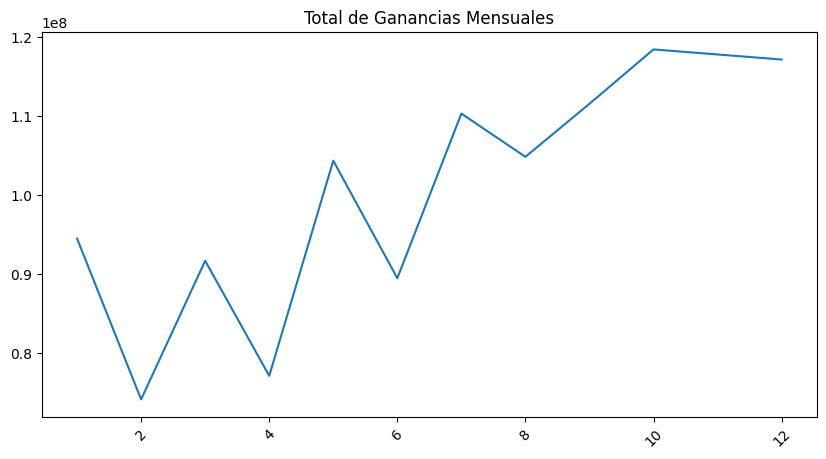

In [33]:
plt.figure(figsize=(10,5))
plt.plot(reporte_mensual["mes"], reporte_mensual["dinero"])
plt.title("Total de Ganancias Mensuales")
plt.xticks(rotation=45)
plt.show()

Nuestros datos ya se ven mas limpios sin las filas con datos erroneos de Abril. La grafica muestra que las ganancias tienen una tendencia a la alta, pero ahondaremos en el analisis. Ahora calculare el porcentaje de crecimiento de ganancias mensual.

In [34]:
reporte_mensual["growth_mom_%"] = (
    reporte_mensual["dinero"].pct_change() * 100
)

In [35]:
reporte_mensual["growth_piezas_%"] = (
    reporte_mensual["piezas"].pct_change() * 100
)

In [36]:
reporte_mensual["growth_mom_%"] = reporte_mensual["growth_mom_%"].round(2)
reporte_mensual["growth_piezas_%"] = reporte_mensual["growth_piezas_%"].round(2)
reporte_mensual

,mes,piezas,dinero,growth_mom_%,growth_piezas_%
0,1,"304,425.00","94,478,904.00",NaN,NaN
1,2,"299,384.10","74,108,955.48",-21.56,-1.66
2,3,"388,202.00","91,668,330.68",23.69,29.67
3,4,"326,404.00","77,096,327.26",-15.90,-15.92
4,5,"403,665.00","104,343,926.21",35.34,23.67
5,6,"370,963.00","89,461,903.33",-14.26,-8.10
6,7,"463,340.00","110,306,591.09",23.30,24.90
7,8,"441,051.00","104,831,775.56",-4.96,-4.81
8,9,"472,978.49","111,554,129.59",6.41,7.24
9,10,"513,019.00","118,434,835.63",6.17,8.47


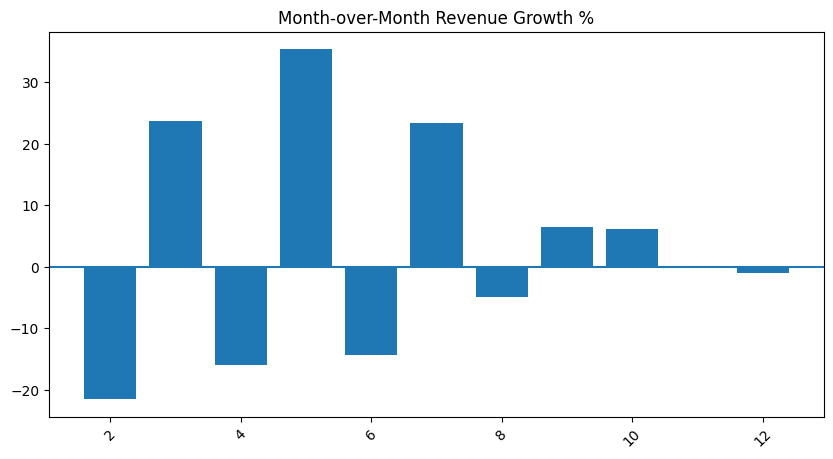

In [37]:
plt.figure(figsize=(10,5))

plt.bar(
    reporte_mensual["mes"],
    reporte_mensual["growth_mom_%"]
)

plt.axhline(0)  # zero reference line
plt.title("Month-over-Month Revenue Growth %")
plt.xticks(rotation=45)

plt.show()

Ahora analizareos las ventas por item

In [38]:
ventas_item = (
    df.groupby("item")
      .agg({
          "piezas": "sum",
          "dinero": "sum"
      })
      .sort_values("dinero", ascending=False)
      .reset_index()
)

ventas_item.head(10)

,item,piezas,dinero
0,3588H,"14,379.00","7,893,635.00"
1,7700,"8,438.00","4,115,083.67"
2,3485H,"8,828.00","3,812,843.81"
3,3443H,"8,199.00","3,359,883.13"
4,60-523,"14,545.00","3,151,254.04"
5,60-522,"14,436.00","3,131,549.79"
6,3587,"15,424.00","2,924,575.94"
7,5447,"8,695.00","2,711,733.39"
8,5369,"7,935.00","2,688,952.74"
9,1330H,"5,732.00","2,650,656.46"


Vamos a analizar el porcentaje acumulado de ganancia por item para evaluar los top items

In [39]:
ventas_item["precio_promedio"] = (
    ventas_item["dinero"] / ventas_item["piezas"]
)

In [40]:
total_revenue = ventas_item["dinero"].sum()

ventas_item["%_participacion"] = (
    ventas_item["dinero"] / total_revenue * 100
)

In [41]:
ventas_item["%_acumulado"] = (
    ventas_item["%_participacion"].cumsum()
)

In [42]:
top_80 = ventas_item[ventas_item["%_acumulado"] <= 80]
top_80.shape

(3258, 6)

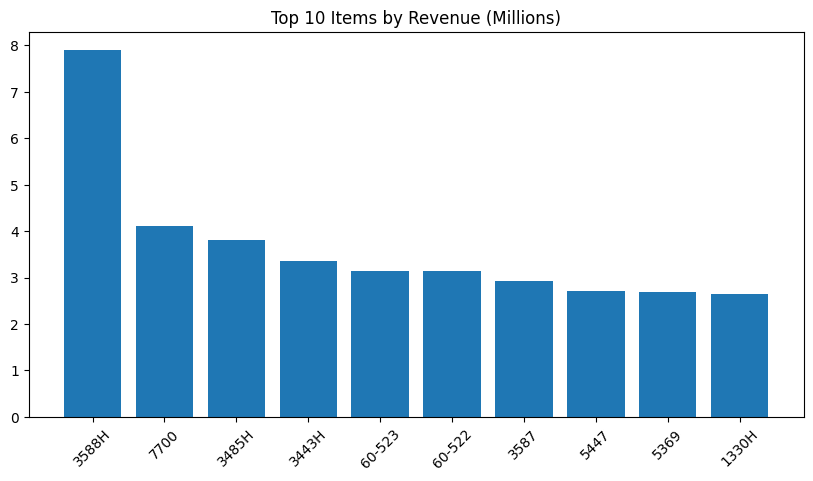

In [43]:
top10 = ventas_item.head(10)

plt.figure(figsize=(10,5))
plt.bar(top10["item"], top10["dinero"] / 1e6)

plt.title("Top 10 Items by Revenue (Millions)")
plt.xticks(rotation=45)
plt.show()

Ahora analizaremos como se comportan estos top items mensualmente

In [44]:
ventas_sku_mes = (
    df.groupby(["item", "mes"])
      .agg({
          "dinero": "sum",
          "piezas": "sum"
      })
      .reset_index()
)

In [45]:
ventas_sku_mes = ventas_sku_mes.sort_values(["item", "mes"])

In [46]:
ventas_sku_mes["growth_%"] = (
    ventas_sku_mes.groupby("item")["dinero"]
                  .pct_change() * 100
)

In [47]:
volatilidad_sku = (
    ventas_sku_mes.groupby("item")["growth_%"]
                  .std()
                  .reset_index()
                  .rename(columns={"growth_%": "volatilidad"})
                  .sort_values("volatilidad", ascending=False)
)

De momento prepare los datos para calcular la volatibilidad de los productos y ahora procedere a calcular las tendencias de venta para analizar declives en demanda de mas del 20% en nuestros items.

In [48]:
def calculate_trend(group):
    if len(group) < 3:
        return np.nan

    x = np.arange(len(group))
    y = group["dinero"].values

    slope = np.polyfit(x, y, 1)[0]
    return slope

trend_sku = (
    ventas_sku_mes.groupby("item")
                  .apply(calculate_trend)
                  .reset_index(name="trend_slope")
)

/tmp/ipython-input-339/2916500296.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_trend)


Ahora combinare volatibilidad con demanda

In [49]:
analysis_sku = trend_sku.merge(volatilidad_sku, on="item")

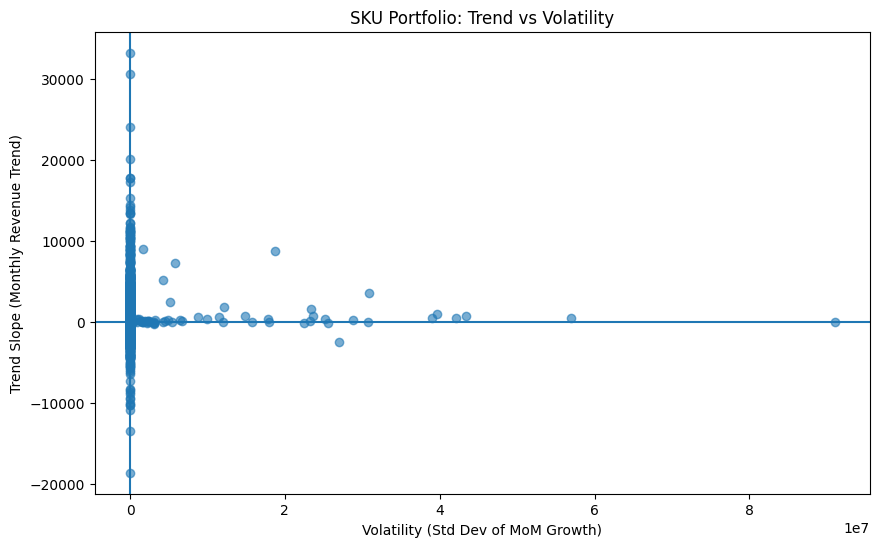

In [50]:
plt.figure(figsize=(10,6))

plt.scatter(
    analysis_sku["volatilidad"],
    analysis_sku["trend_slope"],
    alpha=0.6
)

plt.axhline(0)   # zero growth line
plt.axvline(analysis_sku["volatilidad"].median())  # median volatility

plt.xlabel("Volatility (Std Dev of MoM Growth)")
plt.ylabel("Trend Slope (Monthly Revenue Trend)")
plt.title("SKU Portfolio: Trend vs Volatility")

plt.show()

In [51]:
worst5 = trend_sku.sort_values("trend_slope").head(5)["item"]

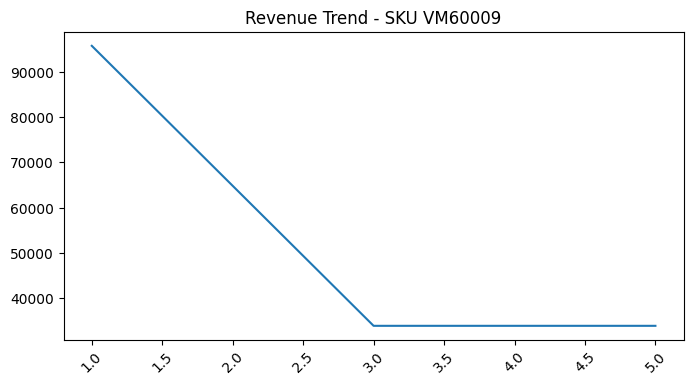

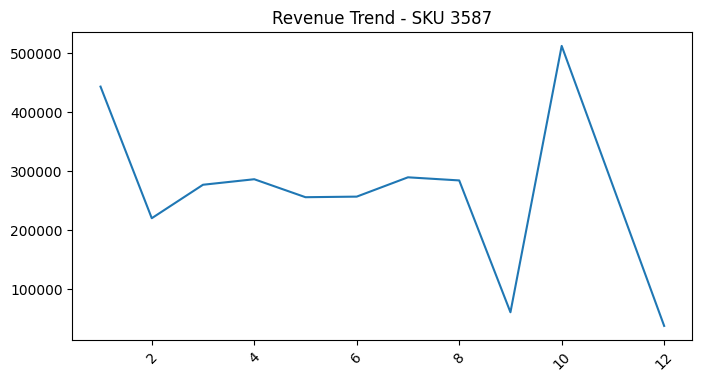

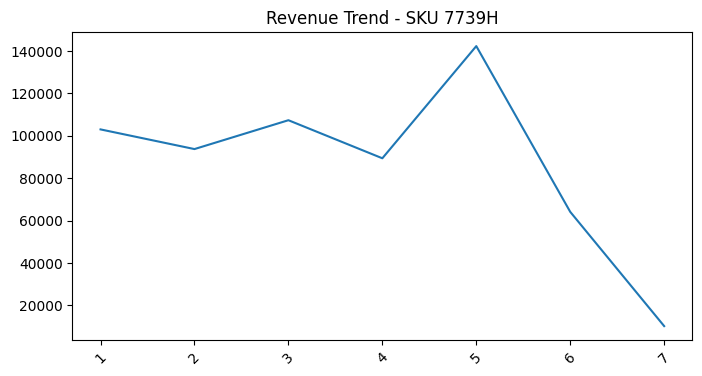

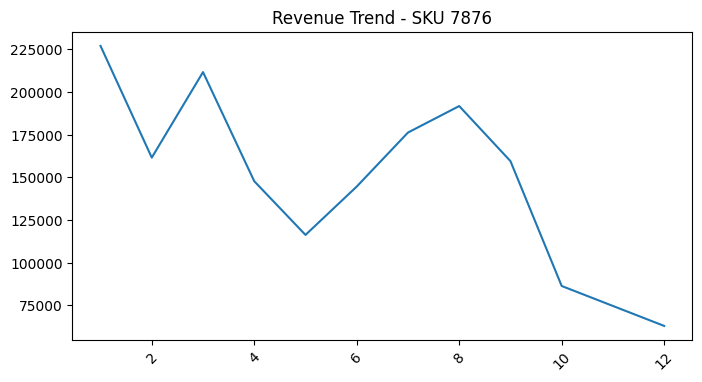

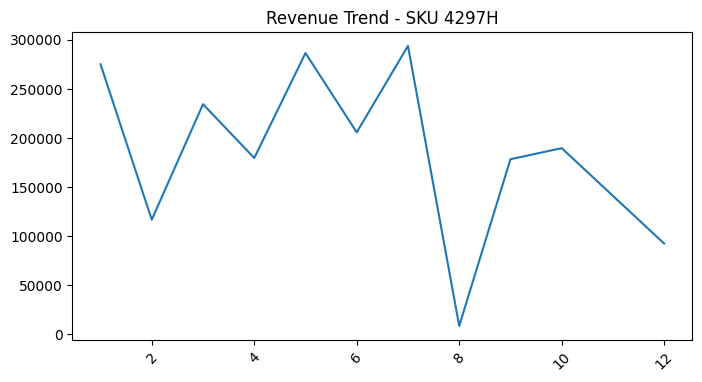

In [52]:
for sku in worst5:
    data = ventas_sku_mes[ventas_sku_mes["item"] == sku]

    plt.figure(figsize=(8,4))
    plt.plot(data["mes"], data["dinero"])
    plt.title(f"Revenue Trend - SKU {sku}")
    plt.xticks(rotation=45)
    plt.show()

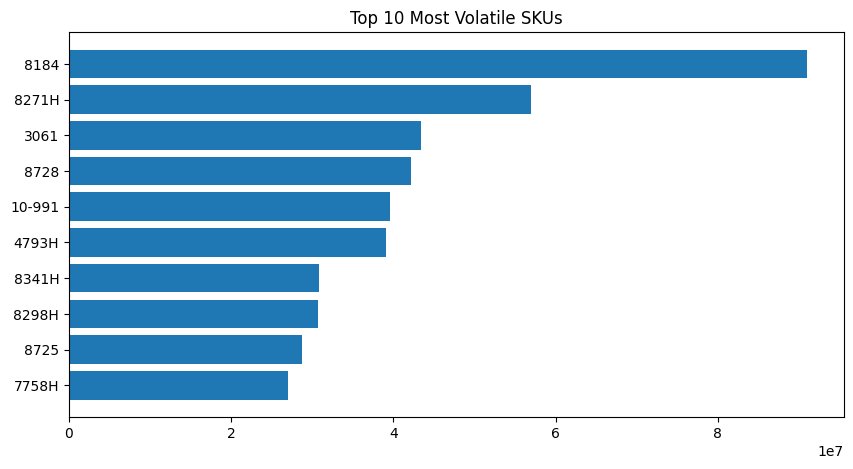

In [53]:
top_vol = volatilidad_sku.head(10)

plt.figure(figsize=(10,5))
plt.barh(top_vol["item"], top_vol["volatilidad"])
plt.title("Top 10 Most Volatile SKUs")
plt.gca().invert_yaxis()
plt.show()

In [54]:
analysis_sku = analysis_sku.merge(
    ventas_item[["item", "dinero"]],
    on="item"
)

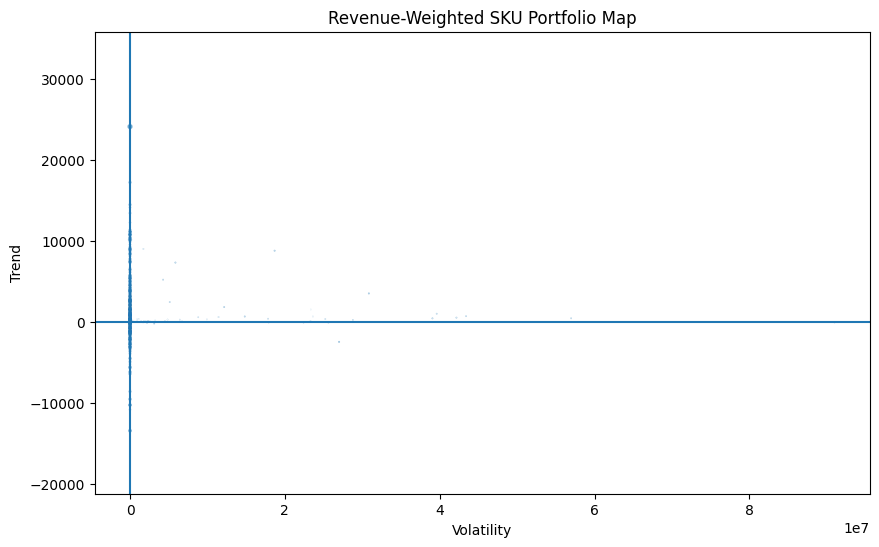

In [55]:
plt.figure(figsize=(10,6))

plt.scatter(
    analysis_sku["volatilidad"],
    analysis_sku["trend_slope"],
    s=analysis_sku["dinero"] / 1e6,
    alpha=0.5
)

plt.axhline(0)
plt.axvline(analysis_sku["volatilidad"].median())

plt.xlabel("Volatility")
plt.ylabel("Trend")
plt.title("Revenue-Weighted SKU Portfolio Map")

plt.show()

In [56]:
top_n = 6

top_volatile_skus = (
    volatilidad_sku
    .sort_values("volatilidad", ascending=False)
    .head(top_n)["item"]
)

In [57]:
volatile_monthly = ventas_sku_mes[
    ventas_sku_mes["item"].isin(top_volatile_skus)
]

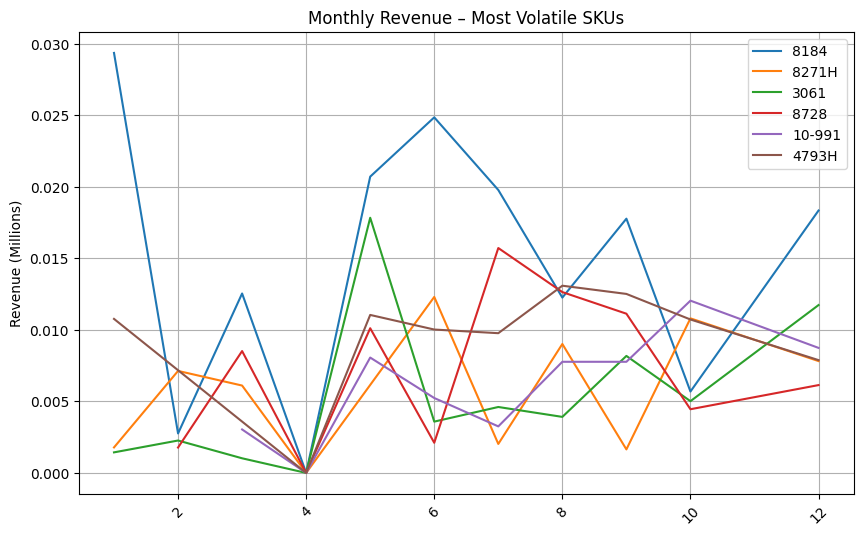

In [58]:
plt.figure(figsize=(10,6))

for sku in top_volatile_skus:
    data = volatile_monthly[volatile_monthly["item"] == sku]
    plt.plot(data["mes"], data["dinero"] / 1e6, label=sku)

plt.title("Monthly Revenue – Most Volatile SKUs")
plt.ylabel("Revenue (Millions)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

SKUs que venden mucho y rotan bien.

SKUs volátiles (ventas impredecibles).

SKUs en caída estructural.

SKUs que prácticamente no rotan.

Es moment de integrar la hoja de movimientos de inventario para analizar con mas detalle las entradas y salidas vs nuestras ventas y el inventario resagado

In [59]:
inventario = pd.read_excel("/content/drive/MyDrive/Python/Forecast/inventarios_compras_mensuales.xlsx")

In [60]:
inventario.head()

,Unnamed: 0,2025,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,2026,Unnamed: 24
0,NaN,Febrero,NaN,Marzo,NaN,Abril,NaN,Mayo,NaN,Junio,...,Septiembre,NaN,Octubre,NaN,Noviembre,NaN,Diciembre,NaN,Enero,NaN
1,NaN,6400659,395269,6735976,131406,6444359,177160,6187570,370047,6117525,...,"5,887,711.00",654826,"6,255,144.00",692773,"6,353,018.00",586171,"6,268,360.00",466176,"6,316,428.00",628302
2,SKU,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,...,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo
3,1002,145,0,159,0,121,0,86,0,129,...,184,120,290,0,260,0,205,0,168,0
4,1003,827,0,730,0,541,0,355,0,249,...,508,0,314,0,101,1000,1019,0,893,0


Se debe dar formato a la base de datos para poder utilizarse

In [61]:
inventario_raw = pd.read_excel(
    "/content/drive/MyDrive/Python/Forecast/inventarios_compras_mensuales.xlsx",
    header=None
)

inventario_raw.head(6)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026,NaN
1,NaN,Febrero,NaN,Marzo,NaN,Abril,NaN,Mayo,NaN,Junio,...,Septiembre,NaN,Octubre,NaN,Noviembre,NaN,Diciembre,NaN,Enero,NaN
2,NaN,6400659,395269,6735976,131406,6444359,177160,6187570,370047,6117525,...,"5,887,711.00",654826,"6,255,144.00",692773,"6,353,018.00",586171,"6,268,360.00",466176,"6,316,428.00",628302
3,SKU,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,...,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo,Existencia,Recibo
4,1002,145,0,159,0,121,0,86,0,129,...,184,120,290,0,260,0,205,0,168,0
5,1003,827,0,730,0,541,0,355,0,249,...,508,0,314,0,101,1000,1019,0,893,0


In [62]:
year_row = inventario_raw.iloc[0]
mes_row = inventario_raw.iloc[1]
tipo_row = inventario_raw.iloc[3]

In [63]:
new_columns = []

current_year = None
current_mes = None

for col in range(len(inventario_raw.columns)):

    if col == 0:
        new_columns.append("item")
        continue

    year_val = year_row[col]
    mes_val = mes_row[col]
    tipo_val = tipo_row[col]

    # Year (only appears once)
    if pd.notna(year_val):
        current_year = str(int(year_val)) if not isinstance(year_val, str) else year_val

    # Month (appears once per block)
    if pd.notna(mes_val):
        current_mes = mes_val

    new_columns.append(f"{current_year}_{current_mes}_{tipo_val}")

In [64]:
inventario = inventario_raw.iloc[4:].copy()
inventario.columns = new_columns
inventario.reset_index(drop=True, inplace=True)

inventario.head()

,item,2025_Febrero_Existencia,2025_Febrero_Recibo,2025_Marzo_Existencia,2025_Marzo_Recibo,2025_Abril_Existencia,2025_Abril_Recibo,2025_Mayo_Existencia,2025_Mayo_Recibo,2025_Junio_Existencia,...,2025_Septiembre_Existencia,2025_Septiembre_Recibo,2025_Octubre_Existencia,2025_Octubre_Recibo,2025_Noviembre_Existencia,2025_Noviembre_Recibo,2025_Diciembre_Existencia,2025_Diciembre_Recibo,2026_Enero_Existencia,2026_Enero_Recibo
0,1002,145,0,159,0,121,0,86,0,129,...,184,120,290,0,260,0,205,0,168,0
1,1003,827,0,730,0,541,0,355,0,249,...,508,0,314,0,101,1000,1019,0,893,0
2,1004,223,0,200,0,180,0,152,0,304,...,225,0,204,0,189,0,166,0,129,0
3,1005,267,0,250,0,233,0,219,0,216,...,130,0,153,0,144,0,129,0,111,0
4,1012,93,0,37,0,15,0,0,208,207,...,76,304,368,0,344,0,300,0,237,0


In [65]:
for col in inventario.columns[1:]:
    inventario[col] = (
        inventario[col]
        .astype(str)
        .str.replace(",", "", regex=False)
    )
    inventario[col] = pd.to_numeric(inventario[col], errors="coerce")

In [66]:
inventario_long = inventario.melt(
    id_vars="item",
    var_name="year_month_tipo",
    value_name="cantidad"
)

In [67]:
inventario_long[["year", "month", "tipo"]] = (
    inventario_long["year_month_tipo"]
    .str.split("_", expand=True)
)

inventario_long.drop(columns="year_month_tipo", inplace=True)

In [68]:
inventario_long.head()

,item,cantidad,year,month,tipo
0,1002,145.00,2025,Febrero,Existencia
1,1003,827.00,2025,Febrero,Existencia
2,1004,223.00,2025,Febrero,Existencia
3,1005,267.00,2025,Febrero,Existencia
4,1012,93.00,2025,Febrero,Existencia


In [69]:
mes_map = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12
}

In [70]:
# (A) Pivot: SKU-month with Existencia / Recibo columns
inventario_pivot = (
    inventario_long
    .pivot_table(
        index=["item", "year", "month"],
        columns="tipo",
        values="cantidad",
        aggfunc="sum"
    )
    .reset_index()
)

# (B) Build month number + datetime month key
inventario_pivot["month_num"] = inventario_pivot["month"].map(mes_map)
inventario_pivot["mes"] = pd.to_datetime(
    dict(
        year=inventario_pivot["year"].astype(int),
        month=inventario_pivot["month_num"].astype(int),
        day=1
    )
)

# (C) Optional: keep only what you’ll actually use
inventario_pivot = inventario_pivot[["item", "mes", "Existencia", "Recibo"]].copy()

# Basic checks
print("Invalid month_num:", inventario_pivot["mes"].isna().sum())
print("Missing Existencia:", inventario_pivot["Existencia"].isna().sum())
print("Missing Recibo:", inventario_pivot["Recibo"].isna().sum())

Invalid month_num: 0
Missing Existencia: 0
Missing Recibo: 0


Nuestros datos de la hoja de inventarios estan listos para utilizarse y analizarze

In [71]:
inv_monthly = (
    inventario_pivot.groupby("mes", as_index=False)
    .agg(
        existencia_total=("Existencia", "sum"),
        recibo_total=("Recibo", "sum"),
        skus=("item", "nunique")
    )
)

inv_monthly["recibo_vs_existencia"] = inv_monthly["recibo_total"] / inv_monthly["existencia_total"]
inv_monthly

,mes,existencia_total,recibo_total,skus,recibo_vs_existencia
0,2025-02-01,"6,400,659.00","395,269.00",12711,0.06
1,2025-03-01,"6,735,976.00","131,406.00",12711,0.02
2,2025-04-01,"6,444,359.00","177,160.00",12711,0.03
3,2025-05-01,"6,187,570.00","370,047.00",12711,0.06
4,2025-06-01,"6,117,525.00","524,722.00",12711,0.09
5,2025-07-01,"6,221,515.00","444,927.00",12711,0.07
6,2025-08-01,"6,127,334.00","413,000.00",12711,0.07
7,2025-09-01,"5,887,711.00","654,826.00",12711,0.11
8,2025-10-01,"6,255,144.00","692,773.00",12711,0.11
9,2025-11-01,"6,353,018.00","586,171.00",12711,0.09


In [72]:
inv_sku = (
    inventario_pivot.groupby("item", as_index=False)
    .agg(
        existencia_prom=("Existencia", "mean"),
        existencia_max=("Existencia", "max"),
        recibo_total=("Recibo", "sum"),
        meses=("mes", "nunique")
    )
    .sort_values("existencia_prom", ascending=False)
)

inv_sku.head(20)

,item,existencia_prom,existencia_max,recibo_total,meses
9975,60-359,"23,152.00","25,419.00",150.00,12
2570,6694,"22,428.17","30,099.00","5,400.00",12
1900,5300,"21,326.75","32,934.00","46,815.00",12
9976,60-359MX,"20,083.25","21,045.00",0.00,12
8438,40-380,"19,688.42","21,829.00",150.00,12
1805,5186,"18,911.83","26,125.00","31,090.00",12
1958,5360,"18,462.17","28,567.00","25,551.00",12
9755,60-142,"17,878.83","18,128.00",0.00,12
10580,61-017MX,"17,359.67","17,445.00",0.00,12
8414,40-357,"17,008.17","18,234.00",240.00,12


In [73]:
# 1) Ensure fecha is datetime
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

# 2) Build clean month-start key
df["mes"] = df["fecha"].dt.to_period("M").dt.to_timestamp()

# 3) Build monthly sales per SKU (this regenerates ventas_sku_mes correctly)
ventas_sku_mes = (
    df.groupby(["item", "mes"], as_index=False)
      .agg(
          piezas=("piezas", "sum"),
          dinero=("dinero", "sum")
      )
)

# 4) Canonical item (optional but safe)
ventas_sku_mes["item"] = ventas_sku_mes["item"].astype(str).str.strip()

In [74]:
def canon_item(x):
    # Converts 1002, "1002", "1002.0", " 1002 " -> "1002"
    s = str(x).strip()
    try:
        # handle "1002.0"
        f = float(s)
        if f.is_integer():
            return str(int(f))
    except:
        pass
    return s

def canon_mes(x):
    # Forces month-start timestamp
    return pd.to_datetime(x).to_period("M").to_timestamp()

# --- SALES KEYS ---
ventas_sku_mes = ventas_sku_mes.copy()
ventas_sku_mes["item_key"] = ventas_sku_mes["item"].apply(canon_item)
ventas_sku_mes["mes_key"]  = ventas_sku_mes["mes"].apply(canon_mes)

# --- INVENTORY KEYS ---
inventario_pivot = inventario_pivot.copy()
inventario_pivot["item_key"] = inventario_pivot["item"].apply(canon_item)
inventario_pivot["mes_key"]  = inventario_pivot["mes"].apply(canon_mes)

# Merge using canonical keys
master = ventas_sku_mes.merge(
    inventario_pivot[["item_key","mes_key","Existencia","Recibo"]],
    on=["item_key","mes_key"],
    how="left"
)

print("Inventory match rate:", f"{master['Existencia'].notna().mean():.2%}")

Inventory match rate: 90.21%


In [75]:
# --- 1) Canonicalize merge keys (do once, clean) ---
ventas_sku_mes["item"] = ventas_sku_mes["item"].astype(str).str.strip()
inventario_pivot["item"] = inventario_pivot["item"].astype(str).str.strip()

ventas_sku_mes["mes"] = pd.to_datetime(ventas_sku_mes["mes"]).dt.to_period("M").dt.to_timestamp()
inventario_pivot["mes"] = pd.to_datetime(inventario_pivot["mes"]).dt.to_period("M").dt.to_timestamp()

# --- 2) Merge sales + inventory ---
master = ventas_sku_mes.merge(
    inventario_pivot[["item", "mes", "Existencia", "Recibo"]],
    on=["item", "mes"],
    how="left"
)

# --- 3) Quick match-rate validation (must be >0 if overlap exists) ---
match_rate = master["Existencia"].notna().mean()
print(f"Inventory match rate: {match_rate:.2%}")

# --- 4) DIO calculation (Days Inventory Outstanding proxy in units) ---
# Average daily units (monthly / 30)
master["avg_daily_units"] = master["piezas"] / 30

# DIO = ending inventory / avg daily sales (avoid divide-by-zero)
master["dio_days"] = np.where(
    master["avg_daily_units"] > 0,
    master["Existencia"] / master["avg_daily_units"],
    np.nan
)

# --- 5) Bin / classify DIO ---
bins = [-np.inf, 180, 400, 600, np.inf]
labels = ["A(<180)", "B(180-400)", "C(400-600)", "D(>600)"]

master["dio_cluster"] = pd.cut(master["dio_days"], bins=bins, labels=labels)

# --- 6) Executive summary table ---
dio_summary = (
    master.groupby("dio_cluster", observed=True, as_index=False)
    .agg(
        skus=("item", "nunique"),
        ventas_mxn=("dinero", "sum"),
        stock_units=("Existencia", "sum"),
        recibo_units=("Recibo", "sum"),
        dio_prom=("dio_days", "mean")
    )
)

dio_summary

Inventory match rate: 90.21%


,dio_cluster,skus,ventas_mxn,stock_units,recibo_units,dio_prom
0,A(<180),6600,"410,031,863.78","4,828,623.00","1,583,019.00",80.16
1,B(180-400),7849,"270,078,718.74","11,077,956.00","878,504.00",282.36
2,C(400-600),6421,"112,869,065.87","8,023,147.00","429,866.00",493.90
3,D(>600),9240,"199,511,186.24","36,547,394.00","777,761.00","2,944.49"


El análisis de Días de Inventario (DIO) muestra una fuerte concentración de capital en productos de muy baja rotación.

Los SKUs del grupo A (<180 días) representan los productos sanos del portafolio: rotan en promedio en 80 días y generan la mayor parte de los ingresos ($410 MM MXN) con un nivel de inventario relativamente bajo.

Los grupos B y C (180–600 días) muestran inventarios elevados que requieren monitoreo, ya que se acercan o superan el umbral óptimo de 400 días.

El hallazgo más relevante está en el grupo D (>600 días):

Más de 9,200 SKUs

Inventario promedio superior a 2,900 días

Concentran aproximadamente 36.5 millones de unidades, es decir, la mayor parte del inventario total.

Esto indica una acumulación significativa de productos de baja rotación, lo que implica:

Capital de trabajo inmovilizado

Ineficiencia en compras y planeación

Riesgo de obsolescencia

En términos estratégicos, la empresa presenta una estructura donde los productos de alta rotación financian el exceso de inventario del portafolio de baja demanda.

Se recomienda priorizar acciones inmediatas en el grupo D (control de compras, revisión de demanda y racionalización de SKUs) para mejorar la eficiencia del capital y liberar liquidez.

In [76]:
top_trapped = (
    master.dropna(subset=["dio_days"])
    .groupby("item", as_index=False)
    .agg(
        dio_prom=("dio_days", "mean"),
        existencia_prom=("Existencia", "mean"),
        ventas_mxn=("dinero", "sum"),
        unidades=("piezas", "sum")
    )
    .sort_values("dio_prom", ascending=False)
    .head(30)
)

top_trapped

,item,dio_prom,existencia_prom,ventas_mxn,unidades
8296,61-017MX,"168,071.88","17,371.20","8,056.03",106.00
3561,3010H-MX,"88,140.00","2,938.00",578.91,1.00
3936,3352-MX,"70,068.89","3,480.67","9,805.43",19.00
11402,7922H-MX,"61,434.53","3,048.67","29,435.07",24.00
2573,2626,"58,411.43","3,083.14","1,712.57",15.00
2306,20-714MX,"54,431.28","9,602.00","6,091.70",74.00
11653,8200-MX,"54,389.50","4,182.20","18,178.48",22.00
2308,20-715MX,"53,496.48","9,632.11","9,261.83",99.00
11473,7994H-MX,"52,282.50","2,298.00","7,379.91",3.00
4566,3974H-MX,"47,488.75","2,911.00","7,360.51",11.00


SKU 61-017MX

DIO: 168,071 días

Eso equivale a más de 460 años de inventario

Vendió solo 106 unidades

Tiene inventario promedio de 17,371 unidades

Esto significa:

Este SKU prácticamente no rota. El inventario es extremadamente superior a su demanda.

Suspender compras inmediatamente

Revisar si tienen ventas en los últimos 6–12 meses

Evaluar liquidación o promociones

Analizar si deben salir del portafolio

Los productos de alta rotación están financiando el exceso de inventario de los productos que no se venden.

Integracion de forecast de cliente y limpieza de formato de fecha

In [77]:
import re

In [78]:
path_forecast = "/content/drive/MyDrive/Python/Forecast/Forecast 2026.xlsx"
fc = pd.read_excel(path_forecast, engine="openpyxl")

In [79]:
fc.columns = fc.columns.astype(str).str.strip()

In [80]:
pat_mes = re.compile(r"^\d{4}-\d{2}-\d{2}")

month_cols = [c for c in fc.columns if pat_mes.match(str(c))]

print("month_cols detectadas:", len(month_cols))
print(month_cols[:5])

month_cols detectadas: 12
['2025-01-01 00:00:00', '2025-02-01 00:00:00', '2025-03-01 00:00:00', '2025-04-01 00:00:00', '2025-05-01 00:00:00']


In [81]:
fc["SKU"] = fc["SKU"].astype(str).str.strip()

In [82]:
fc_long = fc.melt(
    id_vars=["SKU"],
    value_vars=month_cols,
    var_name="mes",
    value_name="unidades"
)

In [83]:
fc_long["mes"] = pd.to_datetime(fc_long["mes"], dayfirst=False, errors="coerce")
fc_long["unidades"] = (
    fc_long["unidades"].astype(str)
    .str.replace(",", "", regex=False)
)
fc_long["unidades"] = pd.to_numeric(fc_long["unidades"], errors="coerce").fillna(0)

In [84]:
fc_long["year"] = fc_long["mes"].dt.year
forecast_anual = (
    fc_long.groupby(["SKU", "year"], as_index=False)
           .agg(unidades_anuales=("unidades", "sum"))
)

forecast_anual.head()

,SKU,year,unidades_anuales
0,10-001,2025,175
1,10-002,2025,812
2,10-003,2025,3674
3,10-004,2025,47
4,10-005,2025,253


El documento de forecast creado por el cliente para 2026 tiene fecha de 2025 asi que se arreglara ese error

In [85]:
# 1) Crear forecast 2026 directo desde fc_long (sin depender de year previo)
forecast_2026 = (
    fc_long.groupby("SKU", as_index=False)
           .agg(unidades_2026=("unidades", "sum"))
)

# 2) Establecer año 2026 explícito
forecast_2026["year"] = 2026

# 3) Renombrar SKU -> item para join posterior
forecast_2026.rename(columns={"SKU": "item"}, inplace=True)

print("SKUs 2026:", len(forecast_2026))
forecast_2026.head()

SKUs 2026: 11402


,item,unidades_2026,year
0,10-001,175,2026
1,10-002,812,2026
2,10-003,3674,2026
3,10-004,47,2026
4,10-005,253,2026


In [86]:
# Asegurar tipos correctos
df["item"] = df["item"].astype(str).str.strip()

precio_sku_2025 = (
    df.groupby("item", as_index=False)
      .agg(
          piezas_2025=("piezas", "sum"),
          dinero_2025=("dinero", "sum")
      )
)

precio_sku_2025["precio_prom_2025"] = (
    precio_sku_2025["dinero_2025"] /
    precio_sku_2025["piezas_2025"]
)

precio_sku_2025.head()

,item,piezas_2025,dinero_2025,precio_prom_2025
0,010-000092,120.00,"217,092.00","1,809.10"
1,010-000115,143.00,"332,888.27","2,327.89"
2,10-001,65.00,"14,833.98",228.22
3,10-002,439.00,"55,605.84",126.66
4,10-003,"2,393.00","714,097.07",298.41


In [87]:
forecast_2026["item"] = forecast_2026["item"].astype(str).str.strip()
precio_sku_2025["item"] = precio_sku_2025["item"].astype(str).str.strip()

forecast_join = forecast_2026.merge(
    precio_sku_2025[["item", "precio_prom_2025"]],
    on="item",
    how="left"
)

forecast_join["ingresos_2026_estimados"] = (
    forecast_join["unidades_2026"] *
    forecast_join["precio_prom_2025"]
)

ingresos_total_2026 = forecast_join["ingresos_2026_estimados"].sum()

print("Ingresos totales previstos 2026 (forecast cliente):",
      f"{ingresos_total_2026:,.2f}")

Ingresos totales previstos 2026 (forecast cliente): 1,683,848,356.25


Ventas totales estimadas por mes

In [88]:
forecast_mensual = (
    fc_long.groupby("mes", as_index=False)
           .agg(unidades_totales=("unidades", "sum"))
           .sort_values("mes")
)

forecast_mensual

,mes,unidades_totales
0,2025-01-01,559662
1,2025-02-01,555138
2,2025-03-01,602238
3,2025-04-01,556456
4,2025-05-01,582901
5,2025-06-01,553673
6,2025-07-01,621670
7,2025-08-01,586448
8,2025-09-01,613642
9,2025-10-01,605982


Crecimiento mensual

In [89]:
forecast_mensual["growth_%"] = (
    forecast_mensual["unidades_totales"]
    .pct_change() * 100
)

forecast_mensual

,mes,unidades_totales,growth_%
0,2025-01-01,559662,NaN
1,2025-02-01,555138,-0.81
2,2025-03-01,602238,8.48
3,2025-04-01,556456,-7.60
4,2025-05-01,582901,4.75
5,2025-06-01,553673,-5.01
6,2025-07-01,621670,12.28
7,2025-08-01,586448,-5.67
8,2025-09-01,613642,4.64
9,2025-10-01,605982,-1.25


Variabilidad mensual

In [90]:
forecast_mensual["unidades_totales"].describe()

,unidades_totales
count,12.00
mean,"574,111.00"
std,"36,642.27"
min,"487,455.00"
25%,"556,126.50"
50%,"573,484.00"
75%,"603,174.00"
max,"621,670.00"


In [91]:
cv = (
    forecast_mensual["unidades_totales"].std() /
    forecast_mensual["unidades_totales"].mean()
)

print("Coeficiente de variación:", round(cv, 2))

Coeficiente de variación: 0.06


El forecast presenta una distribución mensual relativamente uniforme, con variaciones moderadas y sin picos extremos, lo que sugiere una estimación lineal basada en promedio histórico.

Concentracion por sku

In [92]:
top_skus = (
    fc_long.groupby("SKU", as_index=False)
           .agg(unidades_totales=("unidades", "sum"))
           .sort_values("unidades_totales", ascending=False)
)

top_skus["%_acumulado"] = (
    top_skus["unidades_totales"].cumsum() /
    top_skus["unidades_totales"].sum()
)

top_skus.head(20)

,SKU,unidades_totales,%_acumulado
6491,5186,37973,0.01
6612,5300,27457,0.01
4797,40-321,25800,0.01
4085,3586,24959,0.02
313,10-367,22518,0.02
7670,60-522,22465,0.02
7671,60-523,22136,0.03
10265,6694,22094,0.03
503,10-560,20884,0.03
1256,1351,19629,0.04


Join + ingresos 2026

In [93]:
forecast_join = forecast_2026.merge(
    precio_sku_2025[["item","precio_prom_2025"]],
    on="item",
    how="left"
)

forecast_join["ingresos_2026_cliente"] = forecast_join["unidades_2026"] * forecast_join["precio_prom_2025"]

ingresos_2026_cliente_total = forecast_join["ingresos_2026_cliente"].sum()
print("Ingresos totales previstos 2026 (cliente):", f"{ingresos_2026_cliente_total:,.2f}")

print("SKUs sin precio 2025:", f"{forecast_join['precio_prom_2025'].isna().mean():.2%}")

Ingresos totales previstos 2026 (cliente): 1,683,848,356.25
SKUs sin precio 2025: 0.67%


Ventas mensuales totales 2025 y forecast 2026

In [94]:
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["mes"] = df["fecha"].dt.to_period("M").dt.to_timestamp()

ventas_total_2025 = (
    df.groupby("mes", as_index=False)
      .agg(dinero=("dinero","sum"), piezas=("piezas","sum"))
      .sort_values("mes")
)

forecast_total_2026 = ventas_total_2025.copy()
forecast_total_2026["mes"] = forecast_total_2026["mes"] + pd.DateOffset(years=1)
forecast_total_2026.rename(columns={"dinero":"dinero_forecast_2026","piezas":"piezas_forecast_2026"}, inplace=True)

ingresos_2026_modelo_total = forecast_total_2026["dinero_forecast_2026"].sum()
print("Ingresos 2026 (modelo propio - seasonal naive):", f"{ingresos_2026_modelo_total:,.2f}")
print("Ventas 2025 (base):", f"{ventas_total_2025['dinero'].sum():,.2f}")

Ingresos 2026 (modelo propio - seasonal naive): 1,093,441,419.14
Ventas 2025 (base): 1,093,441,419.14


Comparación cliente vs modelo

In [95]:
comp = pd.DataFrame({
    "escenario": ["Cliente (precio 2025 x unidades forecast)", "Modelo propio (replica 2025 mensual)"],
    "ingresos_2026": [ingresos_2026_cliente_total, ingresos_2026_modelo_total]
})
comp["delta_vs_modelo_%"] = (comp["ingresos_2026"] / ingresos_2026_modelo_total - 1) * 100
comp

,escenario,ingresos_2026,delta_vs_modelo_%
0,Cliente (precio 2025 x unidades forecast),"1,683,848,356.25",54.00
1,Modelo propio (replica 2025 mensual),"1,093,441,419.14",0.00


A) El cliente está proyectando mucho más volumen que 2025

(unidades 2026 >> unidades 2025)

B) El precio 2025 que estás usando está inflando ingresos

(precio promedio distorsionado)

C) El forecast del cliente incluye SKUs que no vendieron en 2025

unidades 2025 vs unidades forecast 2026

In [96]:
# Unidades totales 2025
unidades_2025_total = df["piezas"].sum()

# Unidades forecast 2026 cliente
unidades_2026_cliente_total = forecast_2026["unidades_2026"].sum()

print("Unidades 2025:", unidades_2025_total)
print("Unidades forecast 2026 cliente:", unidades_2026_cliente_total)

print("Crecimiento unidades:",
      round(unidades_2026_cliente_total / unidades_2025_total - 1, 2))

Unidades 2025: 4461098.59
Unidades forecast 2026 cliente: 6889332
Crecimiento unidades: 0.54


Se tiene un forecast muy agresivo

precio promedio global

In [97]:
precio_prom_global_2025 = df["dinero"].sum() / df["piezas"].sum()
print("Precio promedio global 2025:", precio_prom_global_2025)

Precio promedio global 2025: 245.10586284481755


In [98]:
precio_implicito_2026 = ingresos_2026_cliente_total / unidades_2026_cliente_total
print("Precio implícito forecast:", precio_implicito_2026)

Precio implícito forecast: 244.41387876895547


El cliente está proyectando:

1,683M → 54% más que 2025.

Eso implica:

O espera crecimiento muy fuerte

O su forecast incluye crecimiento en volumen

O su forecast tiene errores

Forecast cliente proyecta:

$1,683 MM MXN

vs
2025 real: $1,093 MM MXN

+54% crecimiento

Y en unidades:

2025: 4.46 millones
2026 forecast: 6.89 millones
+54% volumen

El precio promedio implícito es consistente (~$245), así que el crecimiento viene por volumen, no por precio.

In [99]:
ventas_2025_sku = (
    df.groupby("item", as_index=False)
      .agg(unidades_2025=("piezas","sum"))
)

comparacion = forecast_2026.merge(
    ventas_2025_sku,
    on="item",
    how="left"
)

comparacion["growth_unidades_%"] = (
    comparacion["unidades_2026"] / comparacion["unidades_2025"] - 1
) * 100

comparacion.sort_values("growth_unidades_%", ascending=False).head(20)

,item,unidades_2026,year,unidades_2025,growth_unidades_%
3424,30-951,655,2026,1.00,"65,400.00"
7961,60-838,589,2026,1.00,"58,800.00"
8646,61-609,528,2026,2.00,"26,300.00"
9886,645196,234,2026,1.00,"23,300.00"
3970,3485H-MX,465,2026,2.00,"23,150.00"
10286,6859,156,2026,1.00,"15,500.00"
8893,61-968,147,2026,1.00,"14,600.00"
103,10-128,128,2026,1.00,"12,700.00"
3348,30-821,96,2026,1.00,"9,500.00"
1736,20-115,95,2026,1.00,"9,400.00"


Modelo naive (replicar 2025 estacionalmente):
→ $1,093 MM

Cliente:
→ $1,683 MM

Diferencia:
→ +54%

Comentario ejecutivo:

El modelo del cliente asume un crecimiento muy agresivo sin evidencia clara de aceleración en la tendencia 2025.

Modelo Naive usado por el cliente
Supuesto:
Todo el portafolio crece ~54% en volumen vs 2025.

Problema estructural:

No distingue SKUs sanos de SKUs muertos.

Asume que productos con 2,900 días de inventario crecerán igual que los de 80 días.

Puede agravar el capital de trabajo.

No considera eficiencia de rotación.

Holt-Winters global

Supuesto:
El negocio crece de forma estructural con estacionalidad.

Problema:

Modela el negocio como si fuera homogéneo.

No corrige el problema de inventario estructural.

Los SKUs muertos siguen pesando en el modelo.

Es estadísticamente más sólido que el naive,
pero no soluciona el problema estratégico.

Forecast por clúster de SKU (el que elegimos)

Principio:

No todos los SKUs son iguales.
Por lo tanto, no todos deben proyectarse igual.

Segmentamos por comportamiento real:

Cluster	Comportamiento	Estrategia Forecast
A (<180 días)	Alta rotación	Crecimiento moderado
B (180–400)	Estables	Crecimiento bajo
C (400–600)	Lentos	Plano
D (>600)	Capital atrapado	Reducción / cero crecimiento



In [100]:
df["item"] = df["item"].astype(str).str.strip()

precio_sku_2025 = (
    df.groupby("item", as_index=False)
      .agg(piezas_2025=("piezas","sum"),
           dinero_2025=("dinero","sum"))
)
precio_sku_2025["precio_prom_2025"] = precio_sku_2025["dinero_2025"] / precio_sku_2025["piezas_2025"]

In [101]:
ventas_2025_sku = (
    df.groupby("item", as_index=False)
      .agg(unidades_2025=("piezas","sum"),
           ingresos_2025=("dinero","sum"))
)

In [102]:
master_tmp = master.copy()
master_tmp["item"] = master_tmp["item"].astype(str).str.strip()
master_tmp["mes"] = pd.to_datetime(master_tmp["mes"]).dt.to_period("M").dt.to_timestamp()

dio_cluster_sku = (
    master_tmp.sort_values("mes")
              .groupby("item", as_index=False)
              .tail(1)[["item","dio_cluster","dio_days"]]
              .rename(columns={"dio_days":"dio_ult"})
)

In [103]:
base_cluster = (
    ventas_2025_sku
      .merge(precio_sku_2025[["item","precio_prom_2025"]], on="item", how="left")
      .merge(dio_cluster_sku[["item","dio_cluster","dio_ult"]], on="item", how="left")
)

In [104]:
growth_assumptions = {
    "A(<180)": 0.15,
    "B(180-400)": 0.05,
    "C(400-600)": 0.00,
    "D(>600)": -0.20
}

base_cluster["growth_factor"] = base_cluster["dio_cluster"].map(growth_assumptions).fillna(0)

In [105]:
base_cluster["growth_factor"] = (
    base_cluster["dio_cluster"]
        .astype(str)          # fuerza a string
        .map(growth_assumptions)
        .astype(float)        # fuerza a numérico
        .fillna(0)
)

In [106]:
base_cluster["unidades_2026_cluster"] = base_cluster["unidades_2025"] * (1 + base_cluster["growth_factor"])
base_cluster["ingresos_2026_cluster"] = base_cluster["unidades_2026_cluster"] * base_cluster["precio_prom_2025"]

ingresos_2026_cluster_total = base_cluster["ingresos_2026_cluster"].sum()

print("Ingresos 2026 (Modelo 3 - por clúster):", f"{ingresos_2026_cluster_total:,.2f}")

Ingresos 2026 (Modelo 3 - por clúster): 1,130,622,641.68


In [107]:
comparacion = pd.DataFrame({
    "escenario": [
        "Cliente (precio 2025 x unidades forecast)",
        "Modelo Naive (replica 2025 mensual)",
        "Modelo 3 (cluster estratégico)"
    ],
    "ingresos_2026": [
        ingresos_2026_cliente_total,
        ingresos_2026_modelo_total,
        ingresos_2026_cluster_total
    ]
})

comparacion["delta_vs_naive_%"] = (comparacion["ingresos_2026"] / ingresos_2026_modelo_total - 1) * 100
comparacion

,escenario,ingresos_2026,delta_vs_naive_%
0,Cliente (precio 2025 x unidades forecast),"1,683,848,356.25",54.00
1,Modelo Naive (replica 2025 mensual),"1,093,441,419.14",0.00
2,Modelo 3 (cluster estratégico),"1,130,622,641.68",3.40


In [108]:
resumen_cluster = (
    base_cluster.groupby("dio_cluster", as_index=False)
      .agg(
          skus=("item","nunique"),
          unidades_2025=("unidades_2025","sum"),
          unidades_2026=("unidades_2026_cluster","sum"),
          ingresos_2025=("ingresos_2025","sum"),
          ingresos_2026=("ingresos_2026_cluster","sum")
      )
)

resumen_cluster["growth_unidades_%"] = (resumen_cluster["unidades_2026"] / resumen_cluster["unidades_2025"] - 1) * 100
resumen_cluster["growth_ingresos_%"] = (resumen_cluster["ingresos_2026"] / resumen_cluster["ingresos_2025"] - 1) * 100

resumen_cluster

/tmp/ipython-input-339/677861273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_cluster.groupby("dio_cluster", as_index=False)


,dio_cluster,skus,unidades_2025,unidades_2026,ingresos_2025,ingresos_2026,growth_unidades_%,growth_ingresos_%
0,A(<180),3973,"1,927,799.00","2,216,968.85","458,688,292.45","527,491,536.32",15.00,15.00
1,B(180-400),2537,"1,163,727.00","1,221,913.35","282,871,288.07","297,014,852.48",5.00,5.00
2,C(400-600),1327,"516,402.00","516,402.00","116,346,640.04","116,346,640.04",0.00,0.00
3,D(>600),4433,"794,234.10","635,387.28","228,827,928.64","183,062,342.91",-20.00,-20.00


Seleccionar ≥20 SKUs y calcular monto de inventario (criterio defendible)
Criterio (para explicar al cliente)

Valuación a costo (no a precio de venta):

Tomamos Existencia más reciente por SKU (unidades).

Multiplicamos por costo unitario promedio ponderado 2025 (costo_total / piezas).
Esto aproxima el valor contable del inventario y evita inflarlo con precios comerciales.

In [109]:
# --- 1) Costo unitario promedio ponderado por SKU ---
df["item"] = df["item"].astype(str).str.strip()

costo_sku = (
    df.groupby("item", as_index=False)
      .agg(costo_total=("costo_total","sum"),
           piezas=("piezas","sum"))
)
costo_sku["costo_uni_prom"] = costo_sku["costo_total"] / costo_sku["piezas"]

# --- 2) Existencia del último mes disponible ---
inventario_pivot["item"] = inventario_pivot["item"].astype(str).str.strip()
inventario_pivot["mes"] = pd.to_datetime(inventario_pivot["mes"]).dt.to_period("M").dt.to_timestamp()

inv_last = (
    inventario_pivot.sort_values("mes")
      .groupby("item", as_index=False)
      .tail(1)[["item","mes","Existencia"]]
)

# --- 3) Valor del inventario a costo ---
inv_value = inv_last.merge(costo_sku[["item","costo_uni_prom"]], on="item", how="left")
inv_value["inventario_mxn"] = inv_value["Existencia"] * inv_value["costo_uni_prom"]

# --- 4) Selección de 20 SKUs (por mayor inventario en MXN) ---
top20_inv = inv_value.sort_values("inventario_mxn", ascending=False).head(20).copy()

top20_inv

,item,mes,Existencia,costo_uni_prom,inventario_mxn
7735,61-755,2026-01-01,"2,339.00","1,720.49","4,024,231.56"
21,60-860,2026-01-01,"13,109.00",282.62,"3,704,830.12"
567,60-858,2026-01-01,"13,288.00",271.99,"3,614,205.50"
6067,4701H-MX,2026-01-01,"8,826.00",302.35,"2,668,541.10"
5864,1578H,2026-01-01,"10,870.00",244.69,"2,659,768.22"
8634,4242H-MX,2026-01-01,"8,254.00",315.62,"2,605,127.48"
7733,61-756,2026-01-01,"1,430.00","1,705.77","2,439,253.66"
6902,1129-MX,2026-01-01,"13,835.00",164.45,"2,275,222.42"
1168,3257H-MX,2026-01-01,"4,104.00",549.07,"2,253,383.28"
8440,1612H-MX,2026-01-01,"6,699.00",322.63,"2,161,327.23"


Clasificar SKUs por días inventario (DIO) con criterios

In [110]:
# Tomar DIO por SKU (promedio o último mes)
master_tmp = master.copy()
master_tmp["item"] = master_tmp["item"].astype(str).str.strip()
master_tmp["mes"] = pd.to_datetime(master_tmp["mes"]).dt.to_period("M").dt.to_timestamp()

dio_sku = (
    master_tmp.groupby("item", as_index=False)
      .agg(dio_prom=("dio_days","mean"),
           dio_cluster=("dio_cluster","first"))
)

# Juntar DIO al top20
top20 = top20_inv.merge(dio_sku, on="item", how="left")
top20

,item,mes,Existencia,costo_uni_prom,inventario_mxn,dio_prom,dio_cluster
0,61-755,2026-01-01,"2,339.00","1,720.49","4,024,231.56",348.63,B(180-400)
1,60-860,2026-01-01,"13,109.00",282.62,"3,704,830.12","4,685.16",D(>600)
2,60-858,2026-01-01,"13,288.00",271.99,"3,614,205.50","5,095.75",D(>600)
3,4701H-MX,2026-01-01,"8,826.00",302.35,"2,668,541.10","36,883.69",D(>600)
4,1578H,2026-01-01,"10,870.00",244.69,"2,659,768.22","1,089.18",D(>600)
5,4242H-MX,2026-01-01,"8,254.00",315.62,"2,605,127.48","15,616.76",D(>600)
6,61-756,2026-01-01,"1,430.00","1,705.77","2,439,253.66",357.74,A(<180)
7,1129-MX,2026-01-01,"13,835.00",164.45,"2,275,222.42","1,974.94",D(>600)
8,3257H-MX,2026-01-01,"4,104.00",549.07,"2,253,383.28","15,876.48",D(>600)
9,1612H-MX,2026-01-01,"6,699.00",322.63,"2,161,327.23","3,156.63",D(>600)


Forecast de inventarios 2026 para esos 20 SKUs (Lead time 120, objetivo 400 días)
Lógica (para explicar)

Simulamos mes a mes:

Inventario final = Inventario inicial + compras planificadas − ventas forecast

Regla de compra:

Si inventario proyectado cae por debajo de 120 días, se activa reorden

Compra para volver al objetivo de 400 días

Mes de orden: se recomienda ordenar 120 días antes del quiebre (aprox 4 meses)

Necesitamos ventas forecast mensual 2026 para esos SKUs

Usaremos el forecast del cliente (fc_2026) porque está mensual.

Si prefieres modelo 3 por cluster, lo adaptamos luego; primero cumplimos lo pedido.

In [111]:
# SKUs a simular
skus_sim = top20["item"].astype(str).tolist()

# Forecast mensual 2026 por SKU (cliente)
fc_2026_monthly = forecast_total_2026.copy()
fc_2026_monthly.rename(columns={"SKU":"item"}, inplace=True)
fc_2026_monthly["item"] = fc_2026_monthly["item"].astype(str).str.strip()
fc_2026_monthly["mes"] = pd.to_datetime(fc_2026_monthly["mes"]).dt.to_period("M").dt.to_timestamp()

ventas_fc_mes_2026 = (
    fc_2026_monthly[fc_2026_monthly["item"].isin(skus_sim)]
      .groupby(["item","mes"], as_index=False)
      .agg(ventas_forecast=("unidades","sum"))
      .sort_values(["item","mes"])
)

# Inventario inicial: existencia del último mes
inv0 = inv_last.set_index("item")["Existencia"].to_dict()

KeyError: 'item'